# Networks and enrichment

---
## Before Class
1. Review slides on GSEA

---
## Learning Objectives
1. Gene Ontology and Pathways
* Gene set enrichment analysis


---
## Pathway enrichment analysis

Often we identify large sets of features (for example, proteins, metabolites, transcribed genes, open chromatin regions, etc) and we would like to identfy if there is any enrichment with known pathways for these data. A common way of doing this is through enrichment analysis. Today we will be using a common enrichment analysis tool called GSEA (Gene Set Enrichment Analysis). The ultimate goal of this method is to identify if there is any enrichment of specific sets of genes given our features.

```
GSEA:
    Rank genes by expression
    Compute cumulative sum over ranked genes as:
        +1/(gene set size) when gene is in set
        -1/(remaining genes) otherwise
    Enrichment = maximum deviation from zero
    
```



In [1]:
def read_gene_sets(filename):
    """ Function to read in gene set file
    
    Args:
        filename (str): file to be read
        
    Returns:
        gene_sets (dict of lists): dictionary with keys of gene set names and values containing list of gene names
    
    Example:
    >>> gene_sets = read_gene_sets("data/temp.gmt")
    >>> gene_sets['demo1']  #doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    ['ATXN1', 'UBQLN4', 'CALM1', 'DLG4', 'MRE11A', 'CTNNB1', 'YWHAG', ...]
    """    
    gene_sets = {}
    file_object = open(filename, 'rt')
    
    for line in file_object:
        values = line.strip().split("\t")
        gene_sets[values[0]] = values[2:]

    return gene_sets

def read_expression(filename):
    """ Function to read in expression file
    
    Args:
        filename (str): file to be read
        
    Returns:
        expression (dict): dictionary with keys of gene set names and values of expression

    Example:
    >>> expression = read_expression("data/temp.txt")
    >>> expression  #doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    {'ATXN1': 16.4567529278529, 'UBQLN4': 13.9894927152905, 'CALM1': 13.7455333730743, ...}
    """  
    expression = {}
    file_object = open(filename, 'rt')
    
    for line in file_object:
        values = line.strip().split("\t")
        expression[values[0]] = float(values[1])

    return expression
    

In [2]:
#Read in our data
gene_sets = read_gene_sets("data/temp.gmt")
expression = read_expression("data/temp.txt")

In [3]:
def GSEA(gene_set, expression):
    """ Function to perform GSEA testing on a gene set and expression data set
    
    Args:
        gene_set (list): list of gene names in a gene set
        expression (dict): dictionary with keys of gene set names and values of expression
        
    Returns:
        enrichment (float): enrichment score for a given gene set
        score (list): list of scores as sorted genes are compared to gene set
        
    Example:
    >>> gene_sets = read_gene_sets("data/temp.gmt")
    >>> expression = read_expression("data/temp.txt")
    >>> GSEA(gene_sets['demo1'], expression)  #doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    (1.0000000000000004, [0, 0.022222222222222223, 0.044444444444444446, 0.06666666666666667, ...)
    """  
    hit_score = 1/len(gene_set)
    miss_score = -1/(len(expression)-len(gene_set))
    print(hit_score, miss_score)
    score = [0]
    enrichment = 0

    sorted_expression = sorted(expression, key=expression.get, reverse=True)

    for i, gene in enumerate(sorted_expression):
        if gene in gene_set:
            new_score = score[i] + hit_score
        else:
            new_score = score[i] + miss_score

        score.append(new_score)
        if new_score > enrichment:
            enrichment = new_score
    
    return enrichment, score


In [9]:
gene_sets = read_gene_sets("data/temp.gmt")
expression = read_expression("data/temp.txt")
enrichment, score = GSEA(gene_sets['demo4'], expression)
print(enrichment)

0.011235955056179775 -4.379625979941313e-05
0.4320122117751872


## Plotting GSEA

Next, we will plot the results of the GSEA analyses as below:

<img src="figures/gsea_plot.png">

In [10]:
def plot_GSEA(scores):
    """ Function to make GSEA plots
    
    Args:
        score (list): list of scores as sorted genes are compared to gene set
    """  
    plt.plot(scores)
    plt.show()

0.022222222222222223 -4.37120251781265e-05
demo1 1.0000000000000004


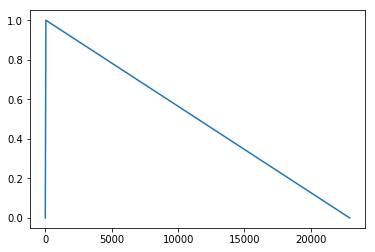

0.027777777777777776 -4.369483527047103e-05
demo2 0.6379276025129387


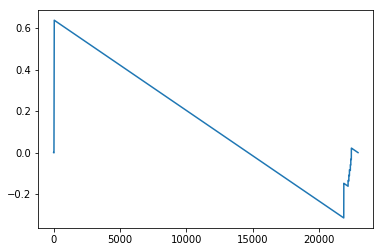

0.013513513513513514 -4.376750700280112e-05
demo3 0.45286712658036266


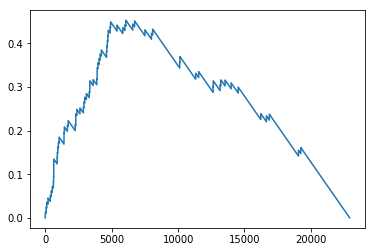

0.011235955056179775 -4.379625979941313e-05
demo4 0.4320122117751872


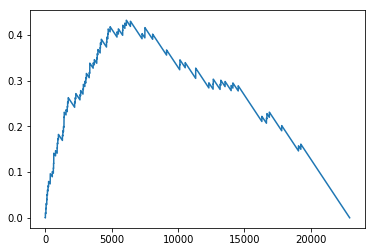

In [13]:
%matplotlib inline
# Here we plot everything
import matplotlib.pyplot as plt

for gene_set in gene_sets:
    enrichment, scores = GSEA(gene_sets[gene_set], expression)
    print(gene_set, enrichment)
    plot_GSEA(scores)

## Assessing significance

For GSEA and other similar models, it is often difficult to accurately model a background expectation. In these cases we can use simulations to estimate an empirical p-value:

```
for 1000 permutations:
    select random gene set of the same size as existing gene set
    calculate enrichment score for this gene set
    
p_val <= Number of permutations with a higher score / total number of permutations
```

In [ ]:
import random

def permute_GSEA(enrichment, gene_set, expression, permutations=1000, seed=42):
    """ Function to perform GSEA testing on a gene set and expression data set
    
    Args:
        enrichment (float): enrichment of the gene set
        gene_set (list): list of gene names in a gene set
        expression (dict): dictionary with keys of gene set names and values of expression
        permutations (int): number of permutations
        seed (int): seed for random.sample
        
    Returns:
        p_val (float): empirical p-pvalue for enrichment
        
    Example:
    >>> gene_sets = read_gene_sets("data/temp.gmt")
    >>> expression = read_expression("data/temp.txt")
    >>> enrichment, scores = GSEA(gene_sets['demo1'], expression)
    >>> permute_GSEA(enrichment, gene_set, expression, permutations=10, seed=42) #doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    0.1
    """
    random.seed(seed)
    enrichment_scores = []
    
    for i in range(permutations):
        random_gene_set = random.sample(list(expression.keys()), len(gene_set))
        
        random_enrichment, random_score = GSEA(random_gene_set, expression)
        
        enrichment_scores.append(random_enrichment)
        
    #Check if random_enrichments are greater than real enrichment
    enrichment_counter = 1
    for value in enrichment_scores:
        if value > enrichment:
            enrichment_counter += 1
    
    return enrichment_counter / permutations

In [ ]:
enrichment, scores = GSEA(gene_sets['demo1'], expression)
permute_GSEA(enrichment, gene_set, expression, permutations=10, seed=42)

In [ ]:
import doctest
doctest.testmod()